# Road Damage Segmentation Training (FastSCNN, UNet, Mask R-CNN, DeepLab)

This notebook trains various segmentation models on the Road Damage Detection dataset (COCO format).
Models covered:
- FastSCNN (implemented in `src/fast_scnn.py`)
- UNet (from `segmentation-models-pytorch`)
- DeepLabV3+ (from `segmentation-models-pytorch`)
- Mask R-CNN (from `torchvision`)

**Prerequisites**:
Ensure `src/dataset.py` and `src/fast_scnn.py` exist and variables point to the correct data path.


In [1]:
import os
import sys
import torch
import numpy as np
import matplotlib.pyplot as plt
import albumentations as A
from albumentations.pytorch import ToTensorV2
from torch.utils.data import DataLoader
import segmentation_models_pytorch as smp

# Add parent directory to path to import src
sys.path.append(os.path.abspath('..'))

from src.dataset import RoadDamageDataset
from src.fast_scnn import FastSCNN

# Global Config
DATA_ROOT = '../data/road-damage-detection-coco'
BATCH_SIZE = 4
LR = 0.001
EPOCHS = 50
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
# DEVICE = 'mps' if torch.backends.mps.is_available() else 'mps'

print(f"Using device: {DEVICE}")


/Users/dikaizm/Documents/PROGRAMMING/ml-ai/transtrack-safeway/venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Using device: cpu


loading annotations into memory...
Done (t=0.02s)
creating index...
index created!
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
Train size: 1620
Valid size: 122
Classes: ['road_damage', 'crack', 'pothole']


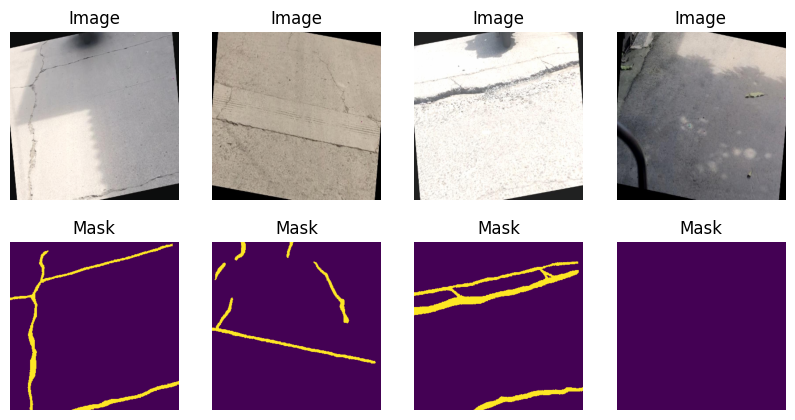

In [2]:
# Define Transformations
train_transform = A.Compose([
    A.Resize(320, 320),
    A.HorizontalFlip(p=0.5),
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    ToTensorV2(),
])

val_transform = A.Compose([
    A.Resize(320, 320),
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    ToTensorV2(),
])

# Create Datasets (Semantic Mode)
train_dataset = RoadDamageDataset(DATA_ROOT, split='train', mode='semantic', transform=train_transform)
valid_dataset = RoadDamageDataset(DATA_ROOT, split='valid', mode='semantic', transform=val_transform)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)
valid_loader = DataLoader(valid_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)

print(f"Train size: {len(train_dataset)}")
print(f"Valid size: {len(valid_dataset)}")
print(f"Classes: {train_dataset.cat_names}")

# Visualization Function
def visualize_batch(loader):
    images, masks = next(iter(loader))
    plt.figure(figsize=(10, 5))
    for i in range(min(BATCH_SIZE, 4)):
        plt.subplot(2, 4, i+1)
        img = images[i].permute(1, 2, 0).numpy()
        # Un-normalize
        img = img * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])
        img = np.clip(img, 0, 1)
        plt.imshow(img)
        plt.title("Image")
        plt.axis('off')
        
        plt.subplot(2, 4, i+5)
        plt.imshow(masks[i].numpy())
        plt.title("Mask")
        plt.axis('off')
    plt.show()

# Visualize a batch
visualize_batch(train_loader)

In [9]:
def train_model(model, train_loader, valid_loader, criterion, optimizer, epochs=10):
    best_iou = 0.0
    
    for epoch in range(epochs):
        model.train()
        train_loss = 0
        
        for images, masks in train_loader:
            images = images.to(DEVICE)
            masks = masks.to(DEVICE)
            
            optimizer.zero_grad()
            outputs = model(images)
            if isinstance(outputs, tuple): # For models that return aux outputs
                outputs = outputs[0]
                
            loss = criterion(outputs, masks)
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item()
            
        print(f"Epoch {epoch+1}/{epochs}, Train Loss: {train_loss/len(train_loader):.4f}")
        
        # Validation
        model.eval()
        valid_loss = 0
        intersection = 0
        union = 0
        
        with torch.no_grad():
            for images, masks in valid_loader:
                images = images.to(DEVICE)
                masks = masks.to(DEVICE)
                
                outputs = model(images)
                if isinstance(outputs, tuple):
                    outputs = outputs[0]
                
                loss = criterion(outputs, masks)
                valid_loss += loss.item()
                
                # IOU Calculation
                preds = torch.argmax(outputs, dim=1)
                intersection += (preds & masks).float().sum().item()
                union += (preds | masks).float().sum().item()
                
        iou = intersection / (union + 1e-6)
        print(f"Valid Loss: {valid_loss/len(valid_loader):.4f}, IOU: {iou:.4f}")
        
        if iou > best_iou:
            best_iou = iou
            torch.save(model.state_dict(), f"best_{model.__class__.__name__}.pth")
            print("Saved Best Model!")


In [10]:
# 1. Train FastSCNN
print("--- Training FastSCNN ---")
NUM_CLASSES = len(train_dataset.cat_names) + 1 # +1 for background 0

fast_scnn = FastSCNN(num_classes=NUM_CLASSES).to(DEVICE)
optimizer = torch.optim.Adam(fast_scnn.parameters(), lr=LR)
criterion = torch.nn.CrossEntropyLoss()

train_model(fast_scnn, train_loader, valid_loader, criterion, optimizer, epochs=EPOCHS)


--- Training FastSCNN ---
Epoch 1/10, Train Loss: 0.2799
Valid Loss: 0.2710, IOU: 0.1103
Saved Best Model!
Epoch 2/10, Train Loss: 0.2247
Valid Loss: 0.2540, IOU: 0.0000
Epoch 3/10, Train Loss: 0.2156
Valid Loss: 0.2509, IOU: 0.0050
Epoch 4/10, Train Loss: 0.2085
Valid Loss: 0.2469, IOU: 0.1082
Epoch 5/10, Train Loss: 0.2061
Valid Loss: 0.2864, IOU: 0.1452
Saved Best Model!
Epoch 6/10, Train Loss: 0.2054
Valid Loss: 0.2242, IOU: 0.1438
Epoch 7/10, Train Loss: 0.2020
Valid Loss: 0.2426, IOU: 0.1099
Epoch 8/10, Train Loss: 0.1992
Valid Loss: 0.2271, IOU: 0.0992
Epoch 9/10, Train Loss: 0.1898
Valid Loss: 0.2286, IOU: 0.2437
Saved Best Model!
Epoch 10/10, Train Loss: 0.1918
Valid Loss: 0.2317, IOU: 0.0963


In [ ]:
# 2. Train UNet (with ResNet34 backbone)
print("--- Training UNet ---")
unet = smp.Unet(
    encoder_name="resnet34",        # choose encoder, e.g. mobilenet_v2 or efficientnet-b7
    encoder_weights="imagenet",     # use `imagenet` pre-trained weights for encoder initialization
    in_channels=3,                  # model input channels (1 for gray-scale images, 3 for RGB, etc.)
    classes=NUM_CLASSES,            # model output channels (number of classes in your dataset)
).to(DEVICE)

optimizer = torch.optim.Adam(unet.parameters(), lr=LR)
criterion = torch.nn.CrossEntropyLoss()

train_model(unet, train_loader, valid_loader, criterion, optimizer, epochs=EPOCHS)


--- Training UNet ---
Epoch 1/10, Train Loss: 0.2817
Valid Loss: 0.2794, IOU: 0.0000
Epoch 2/10, Train Loss: 0.2336
Valid Loss: 0.2572, IOU: 0.0000
Epoch 3/10, Train Loss: 0.2260
Valid Loss: 0.2759, IOU: 0.0000
Saved Best Model!
Epoch 4/10, Train Loss: 0.2235
Valid Loss: 0.3389, IOU: 0.0912
Saved Best Model!
Epoch 5/10, Train Loss: 0.2189
Valid Loss: 0.2824, IOU: 0.1553
Saved Best Model!
Epoch 6/10, Train Loss: 0.2123
Valid Loss: 0.2476, IOU: 0.1094
Epoch 7/10, Train Loss: 0.2049
Valid Loss: 0.2566, IOU: 0.0000
Epoch 8/10, Train Loss: 0.2034
Valid Loss: 0.2447, IOU: 0.1328


In [ ]:
# 3. Train DeepLabV3+
print("--- Training DeepLabV3+ ---")
deeplab = smp.DeepLabV3Plus(
    encoder_name="resnet34", 
    encoder_weights="imagenet", 
    in_channels=3, 
    classes=NUM_CLASSES
).to(DEVICE)

optimizer = torch.optim.Adam(deeplab.parameters(), lr=LR)
criterion = torch.nn.CrossEntropyLoss()

train_model(deeplab, train_loader, valid_loader, criterion, optimizer, epochs=EPOCHS)


In [ ]:
# 4. Train Mask R-CNN
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor

def get_model_instance_segmentation(num_classes):
    # load an instance segmentation model pre-trained on COCO
    model = torchvision.models.detection.maskrcnn_resnet50_fpn(pretrained=True)

    # get number of input features for the classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    # replace the pre-trained head with a new one
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

    # now get the number of input features for the mask classifier
    in_features_mask = model.roi_heads.mask_predictor.conv5_mask.in_channels
    hidden_layer = 256
    # and replace the mask predictor with a new one
    model.roi_heads.mask_predictor = MaskRCNNPredictor(in_features_mask,
                                                       hidden_layer,
                                                       num_classes)
    return model

def collate_fn(batch):
    return tuple(zip(*batch))

# Create Instance Segmentation Datasets
# Note: transforms for Mask R-CNN need to handle bboxes/masks correctly. 
# Here we use basic storage without extensive augs for simplicity in this demo.
train_dataset_inst = RoadDamageDataset(DATA_ROOT, split='train', mode='instance')
valid_dataset_inst = RoadDamageDataset(DATA_ROOT, split='valid', mode='instance')

train_loader_inst = DataLoader(train_dataset_inst, batch_size=2, shuffle=True, num_workers=0, collate_fn=collate_fn)
valid_loader_inst = DataLoader(valid_dataset_inst, batch_size=2, shuffle=False, num_workers=0, collate_fn=collate_fn)

mask_rcnn = get_model_instance_segmentation(NUM_CLASSES).to(DEVICE)
params = [p for p in mask_rcnn.parameters() if p.requires_grad]
optimizer_inst = torch.optim.SGD(params, lr=0.005, momentum=0.9, weight_decay=0.0005)
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer_inst, step_size=3, gamma=0.1)

print("--- Training Mask R-CNN ---")

for epoch in range(EPOCHS):
    mask_rcnn.train()
    i = 0
    for images, targets in train_loader_inst:
        images = list(image.to(DEVICE) for image in images)
        targets = [{k: v.to(DEVICE) for k, v in t.items()} for t in targets]

        loss_dict = mask_rcnn(images, targets)
        losses = sum(loss for loss in loss_dict.values())

        optimizer_inst.zero_grad()
        losses.backward()
        optimizer_inst.step()

        if i % 10 == 0:
            print(f"Epoch {epoch}, Iter {i}, Loss: {losses.item():.4f}")
        i += 1
        
    lr_scheduler.step()
    
    # Save model
    torch.save(mask_rcnn.state_dict(), "best_MaskRCNN.pth")


In [ ]:
# 5. Prediction Visualization (Semantic)
model = fast_scnn # or unet, deeplab
model.eval()

images, masks = next(iter(valid_loader))
images = images.to(DEVICE)
outputs = model(images)
if isinstance(outputs, tuple): outputs = outputs[0]
preds = torch.argmax(outputs, dim=1).cpu().numpy()

plt.figure(figsize=(10, 5))
for i in range(min(BATCH_SIZE, 4)):
    # Image
    plt.subplot(3, 4, i+1)
    img = images[i].cpu().permute(1, 2, 0).numpy()
    img = img * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])
    plt.imshow(np.clip(img, 0, 1))
    plt.title("Image")
    plt.axis('off')
    
    # Ground Truth
    plt.subplot(3, 4, i+5)
    plt.imshow(masks[i].numpy())
    plt.title("GT")
    plt.axis('off')
    
    # Prediction
    plt.subplot(3, 4, i+9)
    plt.imshow(preds[i])
    plt.title("Pred")
    plt.axis('off')
plt.show()
